# Project 2: Tracking User Activity

<b> Created by Elizabeth Khan</b>

<b> Last updated on: 7/10/2021</b>


In this project, you work at an ed tech firm. You've created a service that delivers assessments, and now lots of different customers (e.g., Pearson) want to publish their assessments on it. You need to get ready for data scientists who work for these customers to run queries on the data.

Prepare the infrastructure to land the data in the form and structure it needs
to be to be queried.  You will need to:

- Publish and consume messages with Kafka
- Use Spark to transform the messages. 
- Use Spark to transform the messages so that you can land them in HDFS

## Purpose
The purpose of this Jupyter notebook is to provide our data scientist team with the ability to run queries on our ed tech firm's assessment data. This will leverage Spark to transform messages into a meaningful format to address the following business questions:

1. How many assessments are in the dataset?
2. What's the name of your Kafka topic? How did you come up with that name?
3. How many people took Learning Git?
4. What is the least common course taken? And the most common?
5. What is the overall average score for assessments?
6. What percentage of users passed the assessment?
7. On average, how long does it take users to complete an assessment?

## Deliverables

- docker-compose.yml file ([here](docker-compose.yml))
- console history (elizkhan-history.txt) file ([here](elizkhan-history.txt))
- Jupyter Notebook including Spark transformations (this notebook)




# Data Pipeline Architecture

For <b>Step 1,</b> we use Kafka to publish and consume messages making them available to the Spark instance.

For <b>Step 2,</b> we use Spark to transform these messages into a table format suitable for our data scientist to answer business related questions.

For <b>Step 3,</b> we use Spark to land messages in HDFS so that they can be queried by our data science team.

The Jupyter notebook will follow the outlined data pipeline structure in the diagram below.


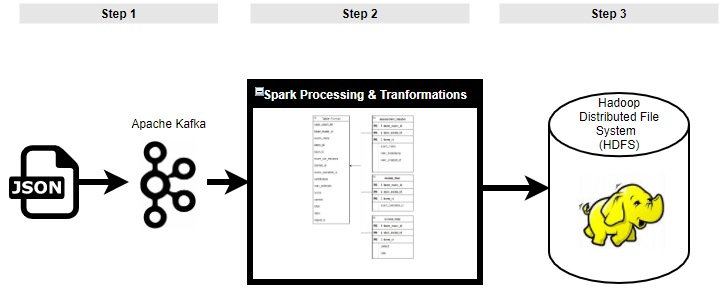

# Setup

This setup is using the latest docker image provided from the <b>midsw205</b> docker repository which was provided to our class. A w205 directory was created within the virtual machine environment in the GCP instance. To connect Jupyter Notebook to the Spark container, Spark has an expose section in the docker-compose.yml file. Moreover, this Jupyter Notebook kernel was started from the command line in the virtual machine and was the ip address was updated to match the virtual machine.

Below is an outline of how my w205 directory is setup for this project.

```
w205/
├── _project-2-elizkhan/
│   ├── docker-compose.yml
│   └── assessment-attempts-20180128-121051-nested.json

```




_Note: the original JSON file can be retreived by running this in the command line in the above directory:_

```bash
curl -L -o assessment-attempts-20180128-121051-nested.json https://goo.gl/ME6hjp
```


# Step 1: Inital Setup and Publish and Consume Messages with Kafka

Prior to executing the Python script below, I spun up the containers for Zookeeper, Kafka, HDFS, and Spark using the docker-compose.yml file and created an "assessments" topic using published and consumed messages with Kafka. 

The complete code that was executed in the command line scripts and annotations can be found below:

1. Going to directory where <b>docker-compose.yml</b> and <b>assessment-attempts-20180128-121051-nested.json</b> are located

```bash
cd ~/w205/project-2-elizkhan
```

2. Bring up the <b>docker-compose</b> cluster
```bash 
docker-compose up -d 
```
3. Check open <b>Docker</b> containers to verify it is up and running
```bash
docker-compose ps
```

4. Check status of <b>zookeeper</b>
```bash
docker-compose logs zookeeper | grep -i binding
```

5. Create a kafka topic named <b>"assessment"</b>. This is a meaningful topic name that describes the contents of the data assessments.
```bash
docker-compose exec kafka kafka-topics --create --topic assessment --partitions 1 --replication-factor 1 --if-not-exists --zookeeper zookeeper:32181
```

6. Check kafka topic
```bash
docker-compose exec kafka kafka-topics --describe --topic assessment --zookeeper zookeeper:32181
```

7. Use <b>kafkacat</b> to publish json data to the "assessment" kafka topic. 
```bash
docker-compose exec mids bash -c "cat /w205/project-2-elizkhan/assessment-attempts-20180128-121051-nested.json | jq '.[]' -c | kafkacat -P -b kafka:29092 -t assessment"
```

8. Create jupyter notebook instance within the <b>Spark</b> environment
```bash
docker-compose exec spark env PYSPARK_DRIVER_PYTHON=jupyter PYSPARK_DRIVER_PYTHON_OPTS='notebook --no-browser --port 8888 --ip 0.0.0.0 --allow-root' pyspark
```

9. Shut down cluster executed ***(Note: this was run after Spark transformations from this Jupyter notebook were complete)***
```bash
docker-compose down
```



# Step 2: Spark Processing and Transformations

This Jupyter notebook will use Spark to read in messages from the Kafka queue, parse the JSON file format, transform the data into a usable format for the data scientists by landing the messages in HDFS.

## Library import
We import all the required Python libraries

In [1]:
# Data manipulation and transformations through Spark
from pyspark.sql.types import *
from pyspark.sql import Row
import pyspark.sql.functions as F

'''Setting spark config to a timezone'''
spark.conf.set("spark.sql.session.timeZone", "UTC")

# Reading json file format
import json

#Other standard python libraries
from datetime import datetime
import numpy as np
import pandas as pd


## Data import

First, we import the data/messages from the "assessment" topic in the Kafka queue.  

The code below subscribes to the kafka "assessment" topic and creates a new spark dataframe with kafka schema.

In [2]:
raw_assessment = spark.read.format("kafka").option("kafka.bootstrap.servers", "kafka:29092").option("subscribe","assessment").option("startingOffsets", "earliest").option("endingOffsets", "latest").load()

# show original table from Kafka, 
# the value column contains the data from the original json file so we will need to extract this further
raw_assessment.show()

+----+--------------------+----------+---------+------+--------------------+-------------+
| key|               value|     topic|partition|offset|           timestamp|timestampType|
+----+--------------------+----------+---------+------+--------------------+-------------+
|null|[7B 22 6B 65 65 6...|assessment|        0|     0|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|assessment|        0|     1|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|assessment|        0|     2|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|assessment|        0|     3|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|assessment|        0|     4|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|assessment|        0|     5|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|assessment|        0|     6|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|assessment|        0|     7|1969-12-31 23:59:...|            0|

## Data Exploration

Next, we extract the value field below to understand the contents of the data and the transformations that need to take place.

To do so, we conduct the following steps:

1. Extract the binary field "value" into a json readable string format.
2. Extract the file using using json.loads into a Spark dataframe
3. Review the dataframe schema and records to understand file contents and structure

In [3]:
# 1) The binary data field value which contains the json file format needs to be extracted from binary into a json readable format

assessment = raw_assessment.selectExpr("CAST(value AS STRING)")

assessment.show(5)


+--------------------+
|               value|
+--------------------+
|{"keen_timestamp"...|
|{"keen_timestamp"...|
|{"keen_timestamp"...|
|{"keen_timestamp"...|
|{"keen_timestamp"...|
+--------------------+
only showing top 5 rows



In [4]:
# 2) convert to spark data frame using json loads library
extracted_assessment = assessment.rdd.map(lambda x: json.loads(x.value)).toDF()

extracted_assessment.show()

/spark-2.2.0-bin-hadoop2.6/python/pyspark/sql/session.py:351: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


+--------------------+-------------+--------------------+------------------+--------------------+------------------+------------+--------------------+--------------------+--------------------+
|        base_exam_id|certification|           exam_name|   keen_created_at|             keen_id|    keen_timestamp|max_attempts|           sequences|          started_at|        user_exam_id|
+--------------------+-------------+--------------------+------------------+--------------------+------------------+------------+--------------------+--------------------+--------------------+
|37f0a30a-7464-11e...|        false|Normal Forms and ...| 1516717442.735266|5a6745820eb8ab000...| 1516717442.735266|         1.0|Map(questions -> ...|2018-01-23T14:23:...|6d4089e4-bde5-4a2...|
|37f0a30a-7464-11e...|        false|Normal Forms and ...| 1516717377.639827|5a674541ab6b0a000...| 1516717377.639827|         1.0|Map(questions -> ...|2018-01-23T14:21:...|2fec1534-b41f-441...|
|4beeac16-bb83-4d5...|        false

We can see that <b> extracted_assessment </b> contains a nested JSON within the sequences column, we will need to use a function to extract desired data elements. Also we will want to convert date fields into a consistent timestamp format. One of the problems we notice with this data set is that the data is nested with key value pairs and arrays that are empty.  Therefore we cannot use *explode* for lower level columns(i.e. not all fields are required and not all values are populated in this nested JSON). To overcome this I will create user defined functions to determine if fields and values exist. 

In [5]:
# 3) print schema to understand field data types 
extracted_assessment.printSchema()


root
 |-- base_exam_id: string (nullable = true)
 |-- certification: string (nullable = true)
 |-- exam_name: string (nullable = true)
 |-- keen_created_at: string (nullable = true)
 |-- keen_id: string (nullable = true)
 |-- keen_timestamp: string (nullable = true)
 |-- max_attempts: string (nullable = true)
 |-- sequences: map (nullable = true)
 |    |-- key: string
 |    |-- value: array (valueContainsNull = true)
 |    |    |-- element: map (containsNull = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: boolean (valueContainsNull = true)
 |-- started_at: string (nullable = true)
 |-- user_exam_id: string (nullable = true)



In total there are <b> 3,280 </b> records from the Kafka queue messages.

In [6]:
print('number of records --> {}\n'.format(extracted_assessment.count()))

number of records --> 3280



## Step 2 Continued: Data Processing

This section uses Spark and functions to extract, join, and transform key data elements to answer the 7 business questions. The master table structure from Spark will be as follows:

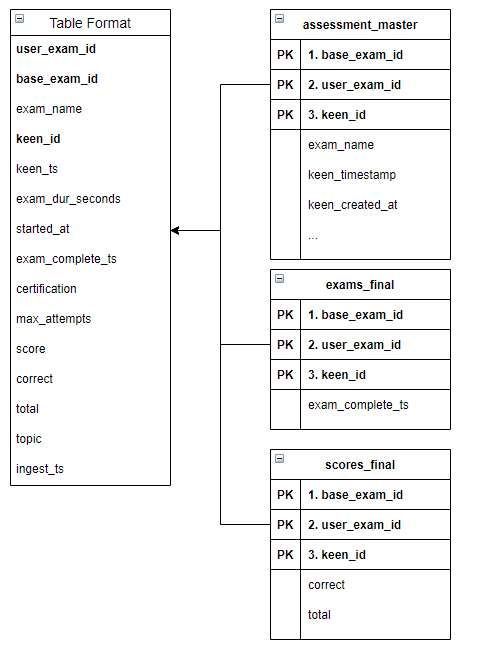

First, we create the master dataframe <b>assessment_master</b> which will include all exam/assessment ids. We will use this as the base table to join to in future Spark Transformations. In this select columns from the first level of the json file structure and convert timestamps so that they are in a consistent format ('GMT'). We will be using the combination of base_exam_id, user_exam_id, and keen_id as a unique identifier or primary key to join other data fields to this base table.

In [7]:
assessment_master = extracted_assessment \
                    .select( \
                        F.from_unixtime(F.col('keen_timestamp')).alias('keen_timestamp') \
                       ,F.col('max_attempts') \
                       ,F.from_utc_timestamp(F.col('started_at'),'GMT').alias('started_at') \
                       ,F.col('base_exam_id') \
                       ,F.col('user_exam_id') \
                       ,F.col('certification') \
                       ,F.col('keen_id') \
                       ,F.col('exam_name') \
                           ) \
                   .distinct()

# Show the results of the base table.
assessment_master.show()

+-------------------+------------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+
|     keen_timestamp|max_attempts|          started_at|        base_exam_id|        user_exam_id|certification|             keen_id|           exam_name|
+-------------------+------------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+
|2018-01-23 14:24:02|         1.0|2018-01-23 14:23:...|37f0a30a-7464-11e...|6d4089e4-bde5-4a2...|        false|5a6745820eb8ab000...|Normal Forms and ...|
|2018-01-04 01:25:28|         1.0|2018-01-04 01:25:...|e1f07fac-5566-4fd...|35b3a5f6-8778-4b7...|        false|5a4d8288b28bd4000...|Git Fundamentals ...|
|2018-01-17 21:21:05|         1.0|2018-01-17 21:16:...|76a682de-6f0c-11e...|f740312d-81e7-41a...|        false|5a5fbe415a791f000...|Learning iPython ...|
|2017-11-27 10:14:31|         1.0|2017-11-27 10:14:...|9ff51f14-7525-11e...|

In [8]:
# Show schema to verify timestamps were created successfully
assessment_master.printSchema()

root
 |-- keen_timestamp: string (nullable = true)
 |-- max_attempts: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- base_exam_id: string (nullable = true)
 |-- user_exam_id: string (nullable = true)
 |-- certification: string (nullable = true)
 |-- keen_id: string (nullable = true)
 |-- exam_name: string (nullable = true)



The <b> get_exam_update_ts </b> function extracts the exam update time stamps ("at") from the "options" level of the json. This extracted column will be used to help us the end time for the exam/ assessment.  We include id fields so that we can join these columns on to the base data frame <b> assessment_master </b>. The reason we had to create a function is because these are not required fields and it is inconsistent across records. (i.e. sometimes the value is missing). The logic below ensures that the field exists.

*Note: In the event we have messages with missing id fields such as user_exam_id the values will will be defaulted to "9999" so that the function will continue to work. Moreover, if necessary, data scientists can use logic in their queries to exclude these from their queries, but based on the above schema this is a required field.*

In [2]:
def get_exam_update_ts(x):
    """
    @function: This function uses a raw dictionary derived from a JSON file format to parse out exam timestamp values
    @param: Takes in extracted json data as a string
    @return: Returns a list of dictonaries containing id and at timestamps
    """
    raw_dict = json.loads(x.value)
    exam_ts_list = []
    
    if "sequences" in raw_dict:
        if "questions" in raw_dict["sequences"]:
            for question in raw_dict["sequences"]["questions"]:
                if "options" in question:
                    for option in question["options"]:
                        if "at" in option:
                            exam_ts_dict = {"user_exam_id": raw_dict.get("user_exam_id","9999")
                                       ,"base_exam_id": raw_dict.get("base_exam_id","9999")
                                       ,"keen_id": raw_dict.get("keen_id","9999")
                                       ,"exam_update_ts": option["at"] }
                            exam_ts_list.append(Row(**exam_ts_dict))
    return exam_ts_list

The <b> get_score </b> function extracts the "total" and "correct" fields which can be used to calculate an assessment score. 
We include id fields so that we can join these columns on to the base data frame <b> assessment_master </b>.

*Note: In the event we have messages with missing id fields such as user_exam_id the values will will be defaulted to "9999" so that the function will continue to work. Moreover, if necessary, data scientists can use logic in their queries to exclude these from their queries, but based on the above schema this is a required field.*

In [10]:
def get_score(x):
    """
    @function: This function uses a raw dictionary derived from a JSON file format to parse out score related values
    @param: Takes in extracted json data as a string
    @return: a list of dictionaries containing ids, correct, and total columns
    """
    raw_dict = json.loads(x.value)
    scores = []
    
    if "sequences" in raw_dict:
        
        if "counts" in raw_dict["sequences"]:
            
            if "correct" in raw_dict["sequences"]["counts"] and "total" in raw_dict["sequences"]["counts"]:
                    
                score_dict = {"user_exam_id": raw_dict.get("user_exam_id","9999"),
                              "base_exam_id": raw_dict.get("base_exam_id","9999"),
                              "keen_id": raw_dict.get("keen_id","9999"),
                              "correct": raw_dict["sequences"]["counts"]["correct"], 
                              "total": raw_dict["sequences"]["counts"]["total"]}
                
                scores.append(Row(**score_dict))
    
    return scores

We now start by creating the two dataframes to join to the master dataframe: <b>scores_final</b> and <b>exams_final</b>

In [11]:
# Create a scores dataframe including the id, "total" ,"correct" fields 
scores = assessment.rdd.flatMap(get_score).toDF()

# ensure there are no duplicates by selecting distinct and create the final dataframe to join to the master

scores_final = scores.select("user_exam_id","base_exam_id","keen_id","correct","total") \
                .distinct()

# show the first row
scores_final.show(1,False)

+------------------------------------+------------------------------------+------------------------+-------+-----+
|user_exam_id                        |base_exam_id                        |keen_id                 |correct|total|
+------------------------------------+------------------------------------+------------------------+-------+-----+
|70073d6f-ced5-4d07-a650-3caca9be2f54|1a233da8-e6e5-48a6-8c3c-806e312cce12|5a67a9ba0600870001247a04|4      |4    |
+------------------------------------+------------------------------------+------------------------+-------+-----+
only showing top 1 row



We extract the <b>latest exam/assessment</b> update to be used as the end time for the assessment duration (<b>exam_complete_ts</b>).

In [12]:
# Create an exams dataframe including the id and "at" (as exam_update_ts) fields
exams = assessment.rdd.flatMap(get_exam_update_ts).toDF()

# select the most recent (max) timestamp for each id so that we have the latest timestamp for an exam update
# convert exam_update_ts to timestamp for assessment duration calculation

exams_final = exams.select("user_exam_id","base_exam_id","keen_id","exam_update_ts") \
                   .groupBy(["user_exam_id","base_exam_id","keen_id"]) \
                   .agg( \
                          F.from_utc_timestamp(F.max(F.col('exam_update_ts')),'GMT').alias('exam_complete_ts') \
                        )



# show the first row

exams_final.show(1,False)

+------------------------------------+------------------------------------+------------------------+-----------------------+
|user_exam_id                        |base_exam_id                        |keen_id                 |exam_complete_ts       |
+------------------------------------+------------------------------------+------------------------+-----------------------+
|0b498b13-1c2c-44e5-a662-dbafb6b5ae35|ad6ad93e-0d28-47e3-b655-1cf8852b254e|5a1ae519e741440001c3a1e5|2017-11-26 16:00:33.802|
+------------------------------------+------------------------------------+------------------------+-----------------------+
only showing top 1 row



This will become one of the temp tables which includes the max and min checkpoints for further analysis purposes.

In [13]:
exams_ts_all = exams.select("user_exam_id","base_exam_id","keen_id","exam_update_ts") \
                   .groupBy(["user_exam_id","base_exam_id","keen_id"]) \
                   .agg( \
                          F.from_utc_timestamp(F.max(F.col('exam_update_ts')),'GMT').alias('max_exam_complete_ts'),
                          F.from_utc_timestamp(F.min(F.col('exam_update_ts')),'GMT').alias('min_exam_complete_ts')\
                        )

exams_ts_all.show(1, False)

+------------------------------------+------------------------------------+------------------------+-----------------------+-----------------------+
|user_exam_id                        |base_exam_id                        |keen_id                 |max_exam_complete_ts   |min_exam_complete_ts   |
+------------------------------------+------------------------------------+------------------------+-----------------------+-----------------------+
|0b498b13-1c2c-44e5-a662-dbafb6b5ae35|ad6ad93e-0d28-47e3-b655-1cf8852b254e|5a1ae519e741440001c3a1e5|2017-11-26 16:00:33.802|2017-11-26 16:00:06.847|
+------------------------------------+------------------------------------+------------------------+-----------------------+-----------------------+
only showing top 1 row



Next I am verifying the schema of the tables to be joined together to produce the master table for querying.

In [14]:
# Print schema of both tables to ensure they are ready for final join
exams_final.printSchema()

scores_final.printSchema()

root
 |-- user_exam_id: string (nullable = true)
 |-- base_exam_id: string (nullable = true)
 |-- keen_id: string (nullable = true)
 |-- exam_complete_ts: timestamp (nullable = true)

root
 |-- user_exam_id: string (nullable = true)
 |-- base_exam_id: string (nullable = true)
 |-- keen_id: string (nullable = true)
 |-- correct: long (nullable = true)
 |-- total: long (nullable = true)



Now create the <b> final_assessment </b> dataframe by joining the two Spark dataframes <b>scores_final</b> and <b>exams_final</b> to the <b>assessment_master</b> based on the identifier columns ("user_exam_id","base_exam_id","keen_id")

In [15]:
final_assessement = assessment_master.join(exams_final, ["user_exam_id","base_exam_id","keen_id"], 'left') \
                                     .join(scores_final, ["user_exam_id","base_exam_id","keen_id"], 'left') \
                                     .distinct() \
                                     .select('user_exam_id' \
                                             ,'base_exam_id' \
                                             ,'exam_name' \
                                             ,'keen_id' \
                                             ,'keen_timestamp' \
                                             ,'started_at' \
                                             ,'exam_complete_ts' \
                                             ,'certification' \
                                             ,'max_attempts' \
                                             ,'correct' \
                                             ,'total'
                                            )

final_assessement.show(1,truncate=False)

final_assessement.printSchema()

+------------------------------------+------------------------------------+-----------------------------------------------------------+------------------------+-------------------+-----------------------+-----------------------+-------------+------------+-------+-----+
|user_exam_id                        |base_exam_id                        |exam_name                                                  |keen_id                 |keen_timestamp     |started_at             |exam_complete_ts       |certification|max_attempts|correct|total|
+------------------------------------+------------------------------------+-----------------------------------------------------------+------------------------+-------------------+-----------------------+-----------------------+-------------+------------+-------+-----+
|0b498b13-1c2c-44e5-a662-dbafb6b5ae35|ad6ad93e-0d28-47e3-b655-1cf8852b254e|Software Architecture Fundamentals Understanding the Basics|5a1ae519e741440001c3a1e5|2017-11-26 16:00:25|2017-11-26

Here we are calculating metrics that would be useful to address the above business questions. 

First, we are calculating the <b> exam duration in seconds</b> by calculating the difference between the started at and exam completed timestamps. This could be a useful metric for data scientists to understand how difficult assessments are and how time consuming they are.

Next we calculate the <b> exam score </b> in order to understand how users are performing and how difficult an exam/ assessment is. To do this we are dividing the correct answers by the total.

We are also converting the keen timestamp to be consistent with the other 'GMT' formatted timestamps.

Finally, we are identifying the name of the Kafka topic "assessment" for data lineage and auditing purposes.

In [16]:
final_assessment2 = final_assessement.withColumn('exam_dur_secs',F.unix_timestamp(F.col("exam_complete_ts")) - F.unix_timestamp(F.col("started_at"))) \
                                     .withColumn('score', F.col('correct')/F.col('total')) \
                                     .withColumn('keen_ts', F.from_utc_timestamp(F.col("keen_timestamp"), 'GMT')) \
                                     .withColumn('topic', F.lit('assessment'))

In [17]:
final_assessment2.show(1, truncate=False)

+------------------------------------+------------------------------------+-----------------------------------------------------------+------------------------+-------------------+-----------------------+-----------------------+-------------+------------+-------+-----+-------------+-----+-------------------+----------+
|user_exam_id                        |base_exam_id                        |exam_name                                                  |keen_id                 |keen_timestamp     |started_at             |exam_complete_ts       |certification|max_attempts|correct|total|exam_dur_secs|score|keen_ts            |topic     |
+------------------------------------+------------------------------------+-----------------------------------------------------------+------------------------+-------------------+-----------------------+-----------------------+-------------+------------+-------+-----+-------------+-----+-------------------+----------+
|0b498b13-1c2c-44e5-a662-dbafb6b5ae35

In this step, I am reordering the columns for the final output table. I am also adding a synthetic ingest date which will become the partition key for the master table. For missing values, I am defaulting missing values to blanks and using a distinct function to prevent duplicate records.

In [18]:
# Reorder and cleanup for final table output
final_assessment2 = final_assessment2\
                                     .select('user_exam_id' \
                                             ,'base_exam_id' \
                                             ,'exam_name' \
                                             ,'keen_id' \
                                             ,'keen_ts' \
                                             ,'exam_dur_secs'
                                             ,'started_at' \
                                             ,'exam_complete_ts' \
                                             ,'certification' \
                                             ,'max_attempts' \
                                             ,'score' \
                                             ,'correct' \
                                             ,'total' \
                                             ,'topic' \
                                             ,F.current_date().alias('ingest_ts')
                                            ) \
                                            .na.fill("") \
                                            .distinct() \
            
            
final_assessment2.show(1,False)
final_assessment2.printSchema()



+------------------------------------+------------------------------------+----------------------+------------------------+-------------------+-------------+-----------------------+-----------------------+-------------+------------+-----+-------+-----+----------+----------+
|user_exam_id                        |base_exam_id                        |exam_name             |keen_id                 |keen_ts            |exam_dur_secs|started_at             |exam_complete_ts       |certification|max_attempts|score|correct|total|topic     |ingest_ts |
+------------------------------------+------------------------------------+----------------------+------------------------+-------------------+-------------+-----------------------+-----------------------+-------------+------------+-----+-------+-----+----------+----------+
|221c76d7-d11c-4f21-a199-3bbb09a9d407|417d1748-76ab-11e6-ae96-a8667f27e5dc|Learning Apache Hadoop|5a4e38f3e9aea60001427c04|2018-01-04 14:23:47|182          |2018-01-04 14:20:3

# Step 3: Write dataframes to HDFS for querying

We are now ready to write the spark DataFrames to HDFS. To do so, we will write to a parquet file.

This is a temporary table that contains data about the assessment scores, we will include the calculated scores in the *assessment_master* table.

In [19]:
scores_final.write.parquet("/tmp/scores")
scores_tmp = spark.read.parquet('/tmp/scores')
scores_tmp.registerTempTable('scores')

scores_tmp_query = "select * from scores limit 10"
spark.sql(scores_tmp_query).show()

+--------------------+--------------------+--------------------+-------+-----+
|        user_exam_id|        base_exam_id|             keen_id|correct|total|
+--------------------+--------------------+--------------------+-------+-----+
|650be2fd-cee6-483...|94b741b2-fc67-4db...|5a2394af42e0a1000...|      0|    4|
|9670dfbd-2983-4b3...|56c8b891-0d34-4a8...|5a4c3079dd97a3000...|      1|    5|
|c09f4017-6772-463...|1a233da8-e6e5-48a...|5a611a6560b7ba000...|      2|    4|
|945fface-a771-4fa...|f3f88f87-7151-11e...|5a34203e38e087000...|      2|    5|
|7ecb6d15-0922-4b6...|747d6bf1-4c14-438...|5a5d6d46be9695000...|      3|    5|
|64eae867-89c2-441...|7e2e0b53-a7ba-458...|5a4b703e4fc7c7000...|      1|    5|
|b3fd088a-8204-443...|e824836a-3835-4e7...|5a5f22ed0a9400000...|      1|    4|
|82c6f15c-6970-405...|786af9ee-7153-11e...|5a4cd75cfe93bc000...|      4|    4|
|4d026bd1-6753-4d5...|6442707e-7488-11e...|5a143bb12c4963000...|      3|    4|
|1d7d3f45-0e49-4d2...|7b398106-8b73-4e7...|5a2e3c269

This creates a temporary table that has all of the max and min checkpoint timestamps when a user selected an answer to a given assessment or exam question.

In [20]:
exams_ts_all.write.parquet("/tmp/exam_checkpoints")
exams_tmp = spark.read.parquet('/tmp/exam_checkpoints')
exams_tmp.registerTempTable('exam_checkpoints')

exams_tmp_query = "select * from exam_checkpoints limit 10"
spark.sql(exams_tmp_query).show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|        user_exam_id|        base_exam_id|             keen_id|max_exam_complete_ts|min_exam_complete_ts|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|008d28fc-3265-4b5...|5d0f436c-ec7b-426...|5a51304e8c7fa0000...|2018-01-06 20:23:...|2018-01-06 20:23:...|
|06637584-d1e1-4a8...|7e2e0b53-a7ba-458...|5a384fd7bc91c7000...|2017-12-18 23:31:...|2017-12-18 23:29:...|
|17308871-cc04-4c5...|56c8b891-0d34-4a8...|5a35652f9cf657000...|2017-12-16 18:25:...|2017-12-16 18:25:...|
|1c323612-b0cd-4f1...|8aaa9a07-1e0a-47b...|5a5e312e4ce2fc000...|2018-01-17 09:07:...|2018-01-17 09:07:...|
|2b1db4ea-1b75-48a...|9547a6eb-715e-11e...|5a5788d4bf9c0b000...|2018-01-11 15:54:...|2018-01-11 15:54:...|
|2c3a4f1e-ab86-402...|8b4488de-43a5-4ff...|5a1d69b1e12af2000...|2017-11-28 13:50:...|2017-11-28 13:49:...|
|41dccdb9-7903-445...|a62e5d35-75e9-1

Here we are creating the <b>assessment_master</b> as a permenant table on HDFS. This process is using Massively Parallel Processing to create the table in HDFS. The parquet file structure we are using is a columnar data structure that is optimized for performance. 

By including the ingestion timestamp partition key, we will enable a more optimized query execution. Moreover, this partition key is based on the consumption pattern of the data to avoid the full table scan by a data scientist (i.e. here we are assuming that data scientists will use this *ingest date* in their filter clause). Also we are repartitioning the table to ensure that a partition does not have too many small files for a given ingestion date.

In [21]:
final_assessment2.repartition(2) \
  .write.mode('append').format("parquet") \
  .partitionBy("ingest_ts") \
  .saveAsTable('assessment_master')

assessment_master_query = "select * from assessment_master limit 10"
spark.sql(assessment_master_query).show()
# final_assessment2.write.parquet("/tmp/assessment summary")

+--------------------+--------------------+--------------------+--------------------+-------------------+-------------+--------------------+--------------------+-------------+------------+-----+-------+-----+----------+----------+
|        user_exam_id|        base_exam_id|           exam_name|             keen_id|            keen_ts|exam_dur_secs|          started_at|    exam_complete_ts|certification|max_attempts|score|correct|total|     topic| ingest_ts|
+--------------------+--------------------+--------------------+--------------------+-------------------+-------------+--------------------+--------------------+-------------+------------+-----+-------+-----+----------+----------+
|221c76d7-d11c-4f2...|417d1748-76ab-11e...|Learning Apache H...|5a4e38f3e9aea6000...|2018-01-04 14:23:47|          182|2018-01-04 14:20:...|2018-01-04 14:23:...|        false|         1.0| 0.75|      3|    4|assessment|2021-07-10|
|07f02f7c-4272-48a...|41858ac3-1394-451...|Introduction to J...|5a4d114de674

## Step 3 Continued:  Business Questions Answered 

Below are in memory Spark queries that answer the business questions:

1. How many assessments are in the dataset?
>There are <b> 107 </b> assessments in the dataset. *(See query1 below)*

In [22]:
query1 = """SELECT Count(DISTINCT base_exam_id) AS total_assessments
            FROM   assessment_master """

spark.sql(query1).show()

+-----------------+
|total_assessments|
+-----------------+
|              107|
+-----------------+



2. What's the name of your Kafka topic? How did you come up with that name?
>The name of the kafka topic is <b>assessment</b>. It was named this way short that it is short and descriptive about the
contents of the data in this case is online ed tech assessment/exam data. *See query2 below)*

In [23]:
query2 = """SELECT DISTINCT topic 
            FROM assessment_master"""

spark.sql(query2).show()

+----------+
|     topic|
+----------+
|assessment|
+----------+



3. How many people took Learning Git?
><b>390</b> people took "Learning Git". Note: this query assumes user exam id is unique by user. *(see query3 below)*

In [24]:
query3 = """SELECT Count(DISTINCT user_exam_id) AS learning_git_users
            FROM   assessment_master
            WHERE  exam_name = 'Learning Git' """

spark.sql(query3).show()

+------------------+
|learning_git_users|
+------------------+
|               390|
+------------------+



4. What is the least common course taken? And the most common?
>The most common course is Learning Git at <b>390</b> users and the least common courses are Learning to Visualize Data with D3.js, Native Web Apps for Android, Operating Red Hat Enterprise Linux Servers and Nulls, Three-valued Logic and Missing Information at just <b>1</b> user each. *(See query4_a and query4_b)*

In [25]:
query4_a = """SELECT exam_name,
                     Count(DISTINCT user_exam_id) AS users
              FROM   assessment_master
              GROUP  BY exam_name,
                        base_exam_id
              ORDER  BY users DESC """

spark.sql(query4_a).show(5, False)


query4_b = """SELECT exam_name,
                     Count(DISTINCT user_exam_id) AS users
              FROM   assessment_master
              GROUP  BY exam_name,
                      base_exam_id
              ORDER  BY users ASC """

spark.sql(query4_b).show(5, False)

+-------------------------------+-----+
|exam_name                      |users|
+-------------------------------+-----+
|Learning Git                   |390  |
|Introduction to Java 8         |158  |
|Intermediate Python Programming|156  |
|Learning to Program with R     |128  |
|Introduction to Python         |122  |
+-------------------------------+-----+
only showing top 5 rows

+-------------------------------------------------+-----+
|exam_name                                        |users|
+-------------------------------------------------+-----+
|Learning to Visualize Data with D3.js            |1    |
|Native Web Apps for Android                      |1    |
|Operating Red Hat Enterprise Linux Servers       |1    |
|Nulls, Three-valued Logic and Missing Information|1    |
|The Closed World Assumption                      |2    |
+-------------------------------------------------+-----+
only showing top 5 rows



5. What is the overall average score for assessments?
>The average score on a given assessment is <b>63</b>. *(See query5 below)*

In [26]:
query5 = """SELECT Round(Avg(score) * 100, 0) AS avg_score
            FROM   assessment_master """

query5tmp = """SELECT Round(Avg(correct / total) * 100, 0) AS avg_score
               FROM   scores """

print("Results from assessment_master table:")
spark.sql(query5).show()

print("Results from scores temp table:")
spark.sql(query5tmp).show()

Results from assessment_master table:
+---------+
|avg_score|
+---------+
|     63.0|
+---------+

Results from scores temp table:
+---------+
|avg_score|
+---------+
|     63.0|
+---------+



6. What percentage of users passed the assessment?
><b>49.9%</b> of students passed an assessment. *(See query6 below)*

In [27]:
query6 = """SELECT Sum(CASE
                         WHEN score > .70 THEN 1
                         ELSE 0
                         END) / Count(*) AS avg_percentage_passed
            FROM   assessment_master """

spark.sql(query6).show()

+---------------------+
|avg_percentage_passed|
+---------------------+
|    0.499691548426897|
+---------------------+



7. On average, how long does it take users to complete an assessment?
>The average assessment takes <b>7.43</b> minutes. *(See query7 below)*

In [29]:
query7 = """SELECT Avg(exam_dur_secs) / 60 AS avg_exam_minutes
            FROM   assessment_master """


### query that explores exam checkpoint duration not exam duration

query7temp = """SELECT Avg(unix_timestamp(max_exam_complete_ts) - unix_timestamp(min_exam_complete_ts)) / 60 AS
                       avg_checkpoint_duration
                FROM   exam_checkpoints """

print("Results from assessment_master table:")

spark.sql(query7).show()

print("Results from exam_checkpoints temp table (Note: this is the checkpoint duration not exam duration):")
spark.sql(query7temp).show()

Results from assessment_master table:
+-----------------+
| avg_exam_minutes|
+-----------------+
|7.431079826732673|
+-----------------+

Results from exam_checkpoints temp table (Note: this is the checkpoint duration not exam duration):
+-----------------------+
|avg_checkpoint_duration|
+-----------------------+
|     1.3742780528052805|
+-----------------------+



In [30]:
sc.stop()

# Next Steps and Future Considerations for the Data Pipeline

This data pipeline is a proof of concept design and would need futher design considerations in order to implement this in a Production environment. See comments below.

1) Assuming we receive JSON files on a daily basis we may want to store these daily JSON files in a low latency storage such as GCP's Cloud Storage and have a trigger that intiates the data pipeline when a file lands in the cloud storage. Moreover, this streaming process should be determined based on the needs of the data scientists and the queries they are using on a regular basis.

2) For data scientists, we should consider connecting this pipeline to a Presto query engine as it is distributed SQL query engine that is more performant.

3) We need to consider the performance of this code as there are more opportunities for improvement especially with the functions for parsing the JSON. We could simplify this if we have more insights into required fields (appropriate schema definition) in the JSON file.